In [1]:
##### Assigning geometric properties #####
# Geometric properties - physical sizes of pores and throats - OpenPNM can calculate automatically
import numpy as np
import matplotlib.pyplot as plt
import openpnm as op
op.visualization.set_mpl_style()

In [2]:
# setting up sample network
np.random.seed(0)
pn = op.network.Cubic([20, 20, 20], spacing=5e-5)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x207c798d490>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                   8000 / 8000
  3  throat.conns                                                22800 / 22800
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.xmin                                                             400
  3  pore.xmax                                                             400
  4  pore.ymin                                                             400
  5 

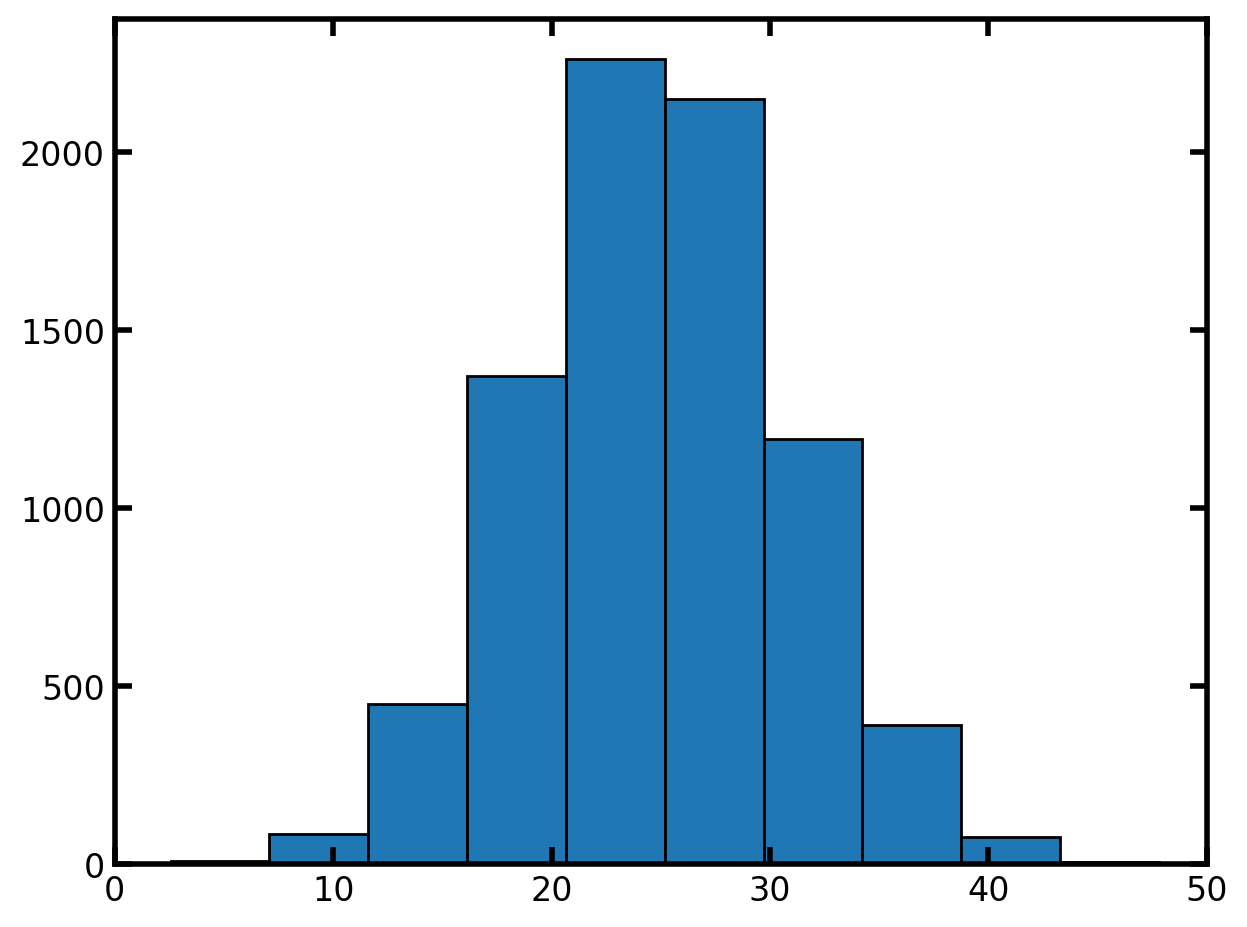

In [3]:
## 1. Manual calculation (not recommended)
# pores: normal distribution generator using stats
np.random.seed(0)
import scipy.stats as spst
psd = spst.norm.rvs(loc=25, scale=6, size=pn.Np)
plt.hist(psd, edgecolor='k')
plt.xlim([0, 50]);

In [4]:
# making sure it's in range, converting to SI
print(psd.min())
print(psd.max())
pn['pore.diameter'] = psd*1e-6  # um to m

2.5593961722893255
47.80996128980269


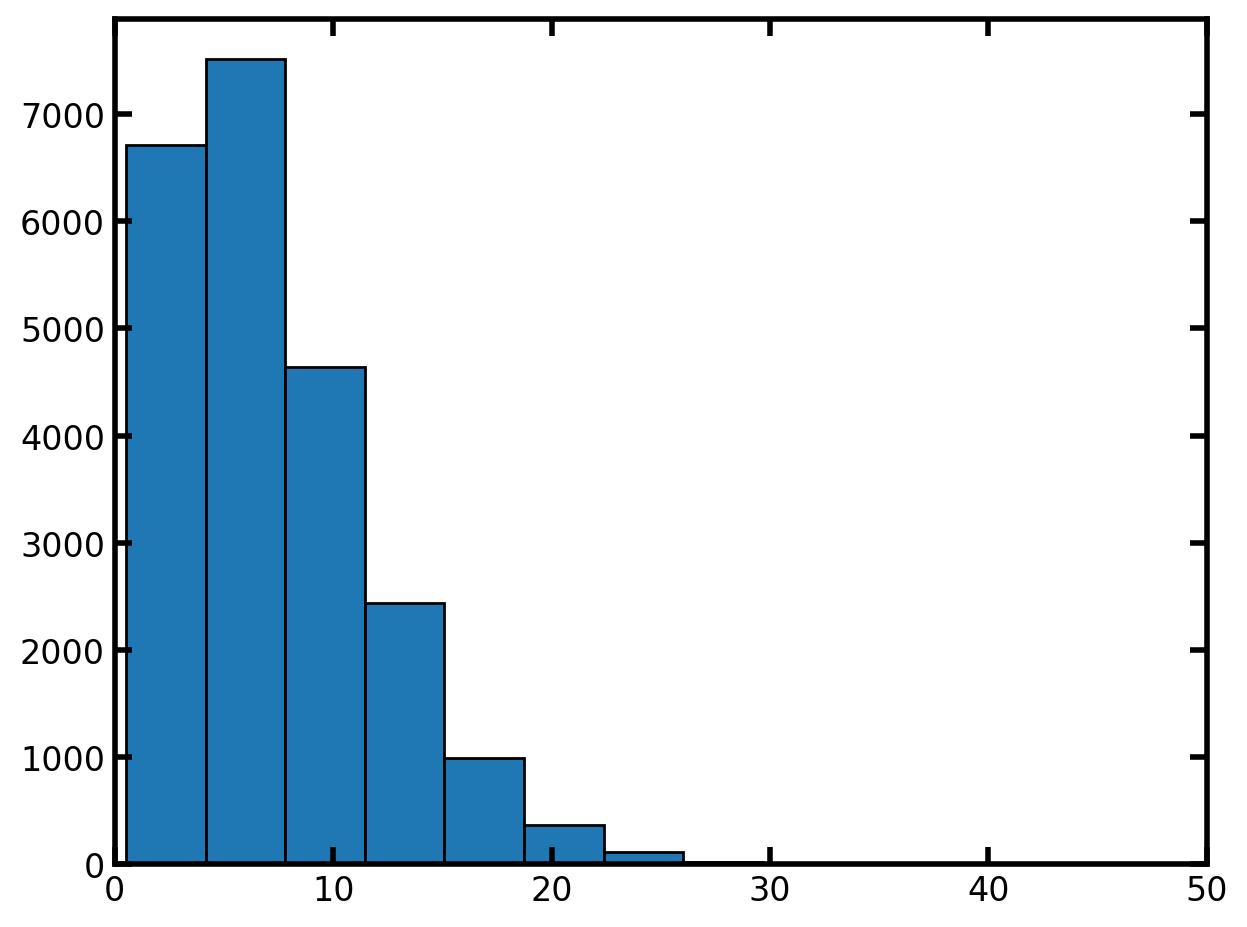

In [5]:
# throats: distribution generator using stats
np.random.seed(0)
tsd = spst.weibull_min.rvs(c=1.5, loc=.5, scale=7.5, size=pn.Nt)
plt.hist(tsd, edgecolor='k')
plt.xlim([0, 50]);

In [6]:
print(tsd.min())
print(tsd.max())
pn['throat.diameter'] = tsd*1e-6  # um to m

0.5130345457395142
36.96861960231873


In [7]:
# danger: problematic pore throat connections where throat is larger than pore (due to random assignment)
hits = np.any(pn['pore.diameter'][pn.conns].T < pn['throat.diameter'], axis=0)
hits.sum()

564

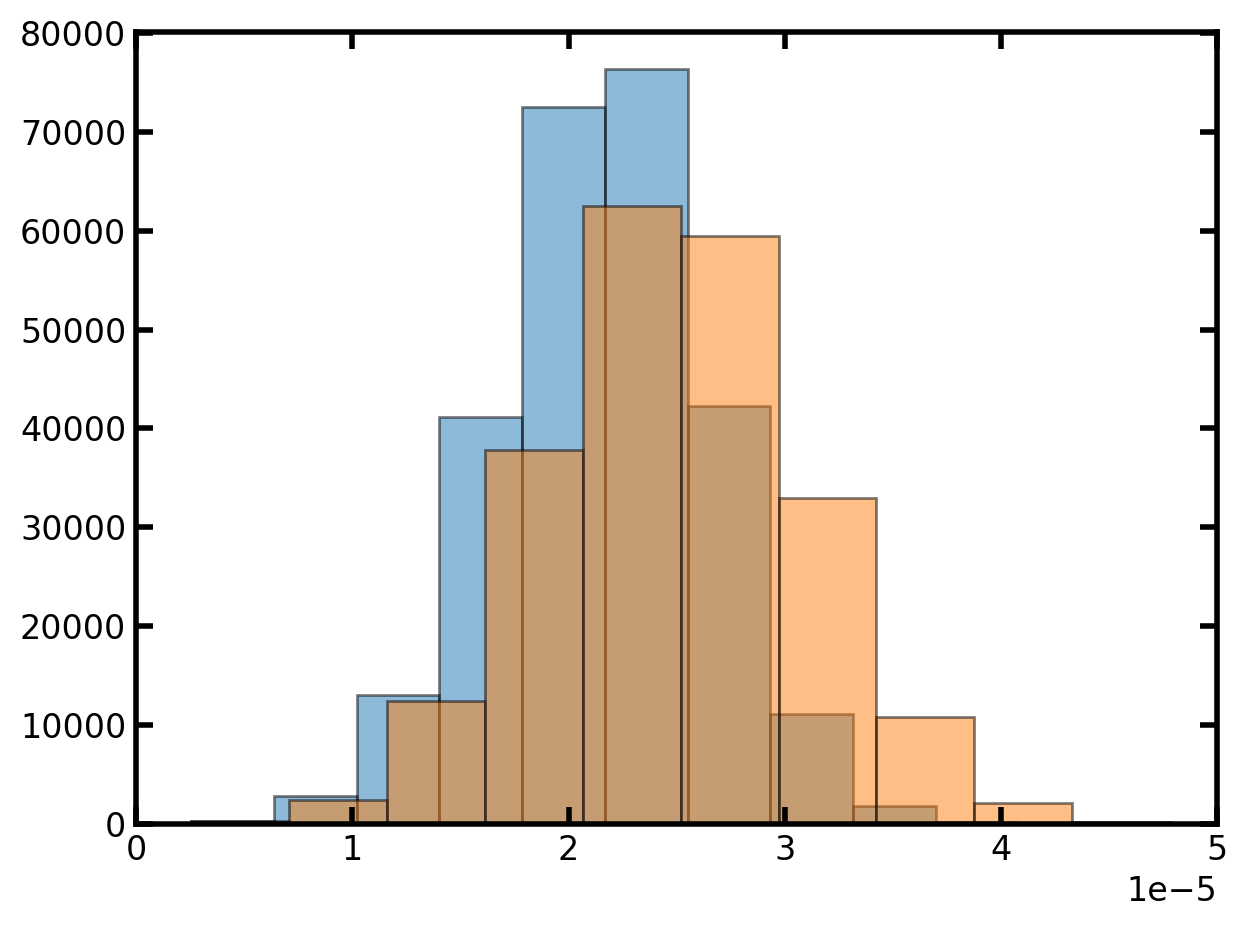

In [8]:
# safer way: assign pore sizes randomly, then assign throat to be smaller than the smallest pore it's connected to
tsd = np.amin(pn['pore.diameter'][pn.conns], axis=1)
plt.hist(tsd, edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.xlim([0, 50e-6]);

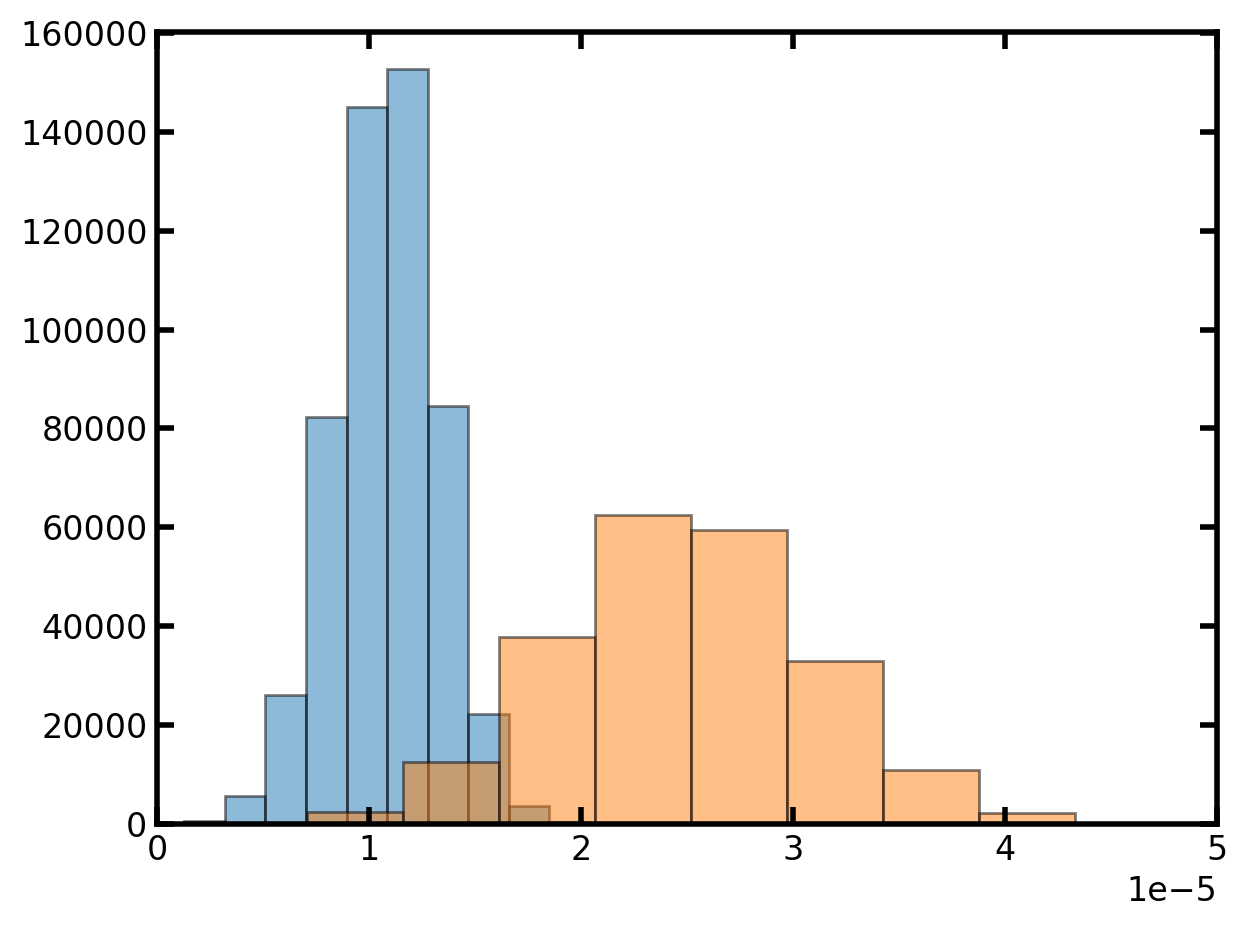

In [9]:
# safer way as well: have a multiplication factor to make the throat smaller than pores
pn['throat.diameter'] = tsd*0.5
plt.hist(pn['throat.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.xlim([0, 50e-6]);

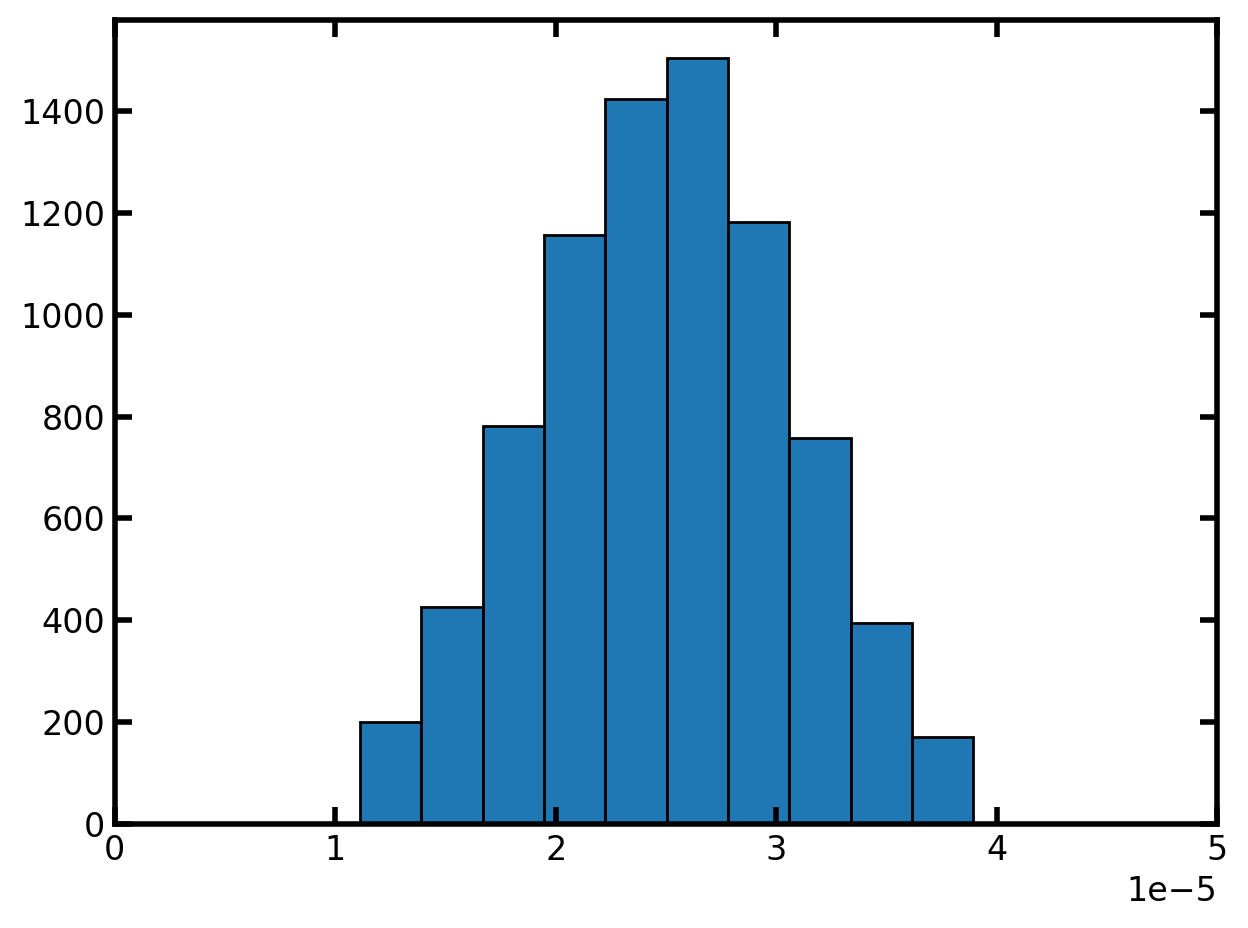

In [10]:
# yet another safer way: randomly generate seeds 
lo, hi = 0.01, 0.99
pn['pore.seed'] = np.random.rand(pn.Np)*(hi - lo) + lo

import scipy.stats as spst
psd = spst.norm.ppf(loc=25, scale=6, q=pn['pore.seed'])
pn['pore.diameter'] = psd*1e-6
plt.hist(pn['pore.diameter'], edgecolor='k')
plt.xlim([0, 50e-6]);

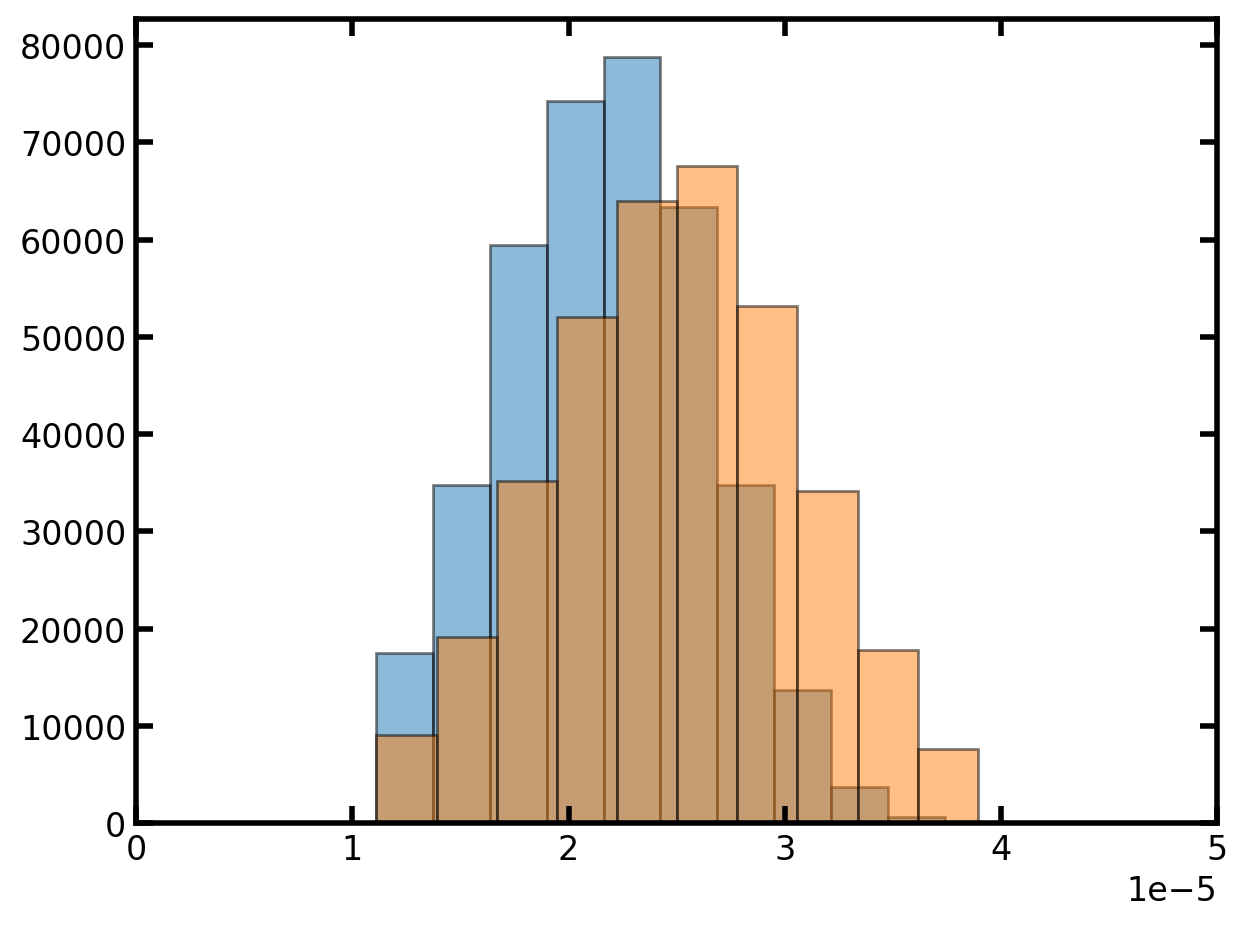

In [11]:
pn['throat.seed'] = np.amin(pn['pore.seed'][pn.conns], axis=1)
tsd = spst.norm.ppf(loc=25, scale=6, q=pn['throat.seed'])
pn['throat.diameter'] = tsd*1e-6
plt.hist(pn['throat.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.xlim([0, 50e-6]);

In [12]:
# assuming cubic pores and throats
# computing throat length
# three steps
# 1. Get the pore radiu
# 2. Get the pore-to-pore distance
# 3. Throat length = pore-to-pore distance - pore radii
R1, R2 = (pn['pore.diameter'][pn.conns]/2).T
L_total = np.sqrt(np.sum(np.diff(pn.coords[pn.conns], axis=1).squeeze()**2, axis=1))
Lt = L_total - R1 - R2
print(L_total)

[5.e-05 5.e-05 5.e-05 ... 5.e-05 5.e-05 5.e-05]


In [14]:
# computing pore surface areas
# surface area = total area of pore sphere - cross sectional area of throats
At = pn['throat.diameter']**2
SAp = (pn['pore.diameter']**2)*6
np.subtract.at(SAp, pn.conns[:, 0], At)
np.subtract.at(SAp, pn.conns[:, 1], At)
print(SAp)

[9.08485305e-10 5.68134509e-09 2.33947201e-09 ... 6.57211706e-10
 1.92152447e-09 1.72429278e-09]


In [16]:
## 2. Using Pore-scale Models from Library
# make a new network again
np.random.seed(0)
pn = op.network.Cubic([20, 20, 20], spacing=5e-5)

In [19]:
# random number can be assigned by creating a randomizer model
f = op.models.geometry.pore_seed.random
pn.add_model(propname='pore.seed', 
             model=f,
             seed=None,  # Seed value provided to numpy's random number generator.
             num_range=[0.01, 0.99],)

In [20]:
print(pn.models)

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#   Property Name                       Parameter                 Value
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1   pore.coordination_number@all        model:                    coordination_number
                                        regeneration mode:        deferred
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2   throat.spacing@all                  model:                    pore_to_pore_distance
                                        regeneration mode:        deferred
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
3   pore.seed@all                       model:                    random
                                        seed:                     None
                                        num_range:                [0.01, 0.99]
                                     

In [21]:
# minimum value is set for each throat
f = op.models.geometry.throat_seed.from_neighbor_pores
pn.add_model(propname='throat.seed', 
             model=f,
             prop='pore.seed',
             mode='min')

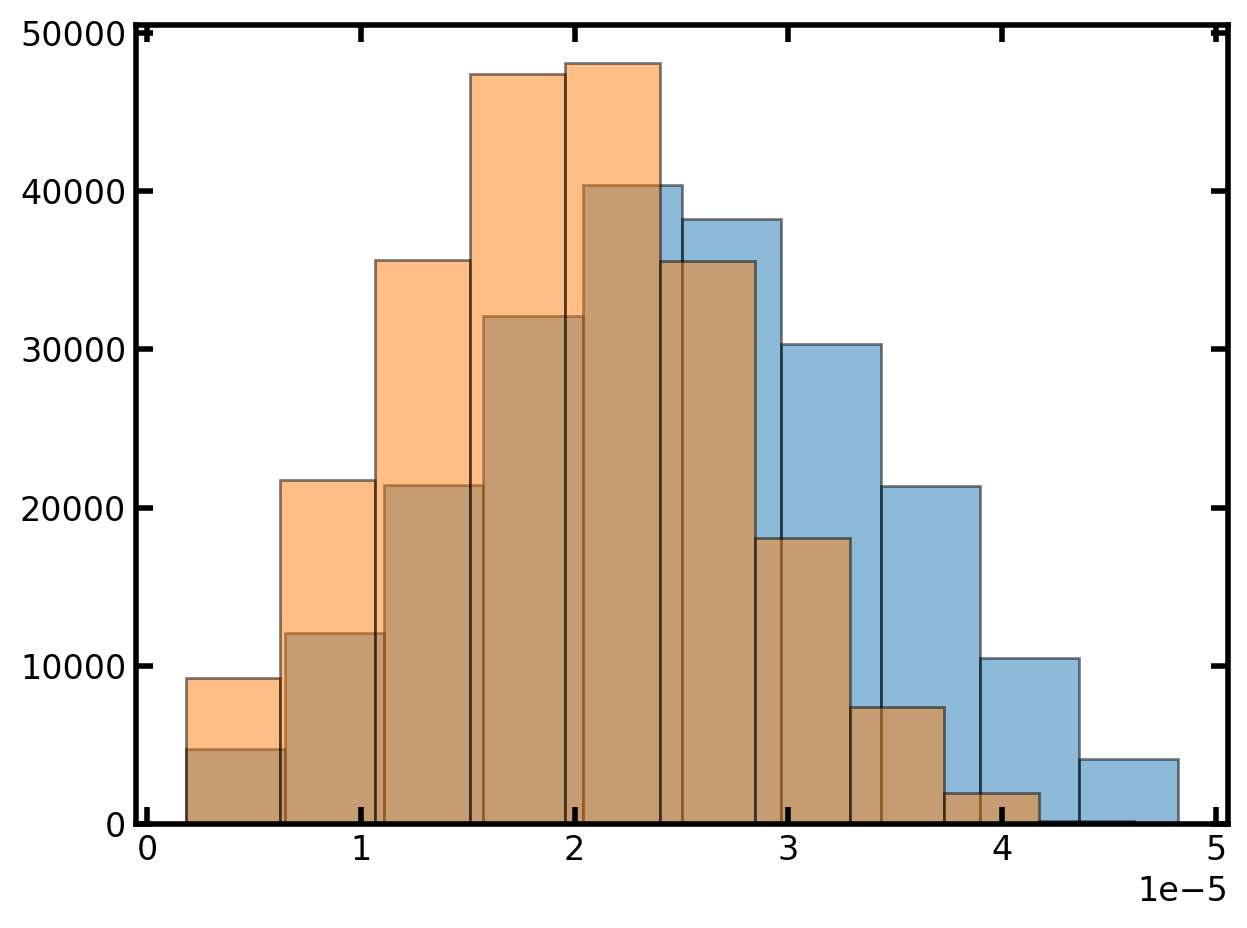

In [24]:
# pore and throat size distribution is computed
f = op.models.geometry.pore_size.normal
pn.add_model(propname='pore.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='pore.seed')
f = op.models.geometry.throat_size.normal
pn.add_model(propname='throat.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5)
plt.hist(pn['pore.diameter'], edgecolor='k', density=True, alpha=0.5)
plt.hist(pn['throat.diameter'], edgecolor='k', density=True, alpha=0.5);

In [33]:
# we can then calculate the throat length, pore volume, and throat volume
# note: we have to subtract the overlapping volume (called lens) from the throat volume 
f = op.models.geometry.throat_length.spheres_and_cylinders
pn.add_model(propname='throat.length',
             model=f)
f1 = op.models.geometry.pore_volume.sphere 
pn.add_model(propname='pore.volume',
             model=f1)
f2 = op.models.geometry.throat_volume.cylinder
pn.add_model(propname='throat.total_volume',
             model=f2)
f3 = op.models.geometry.throat_volume.lens
pn.add_model(propname='throat.lens_volume',
             model=f3)
f4 = op.models.misc.difference
pn.add_model(propname='throat.volume',
             model=f4,
             props=['throat.total_volume', 'throat.lens_volume'])

In [34]:
print("Volumes of full throats:", pn['throat.total_volume'][:3])
print("Volumes of lenses:", pn['throat.lens_volume'][:3])
print("Actual throat volumes:", pn['throat.volume'][:3])

Volumes of full throats: [1.70606123e-14 1.49642200e-14 8.56617280e-15]
Volumes of lenses: [4.30295464e-15 3.70683677e-15 1.60690817e-15]
Actual throat volumes: [1.27576577e-14 1.12573832e-14 6.95926463e-15]


In [35]:
## 3. Using Predefined Collection of Models
# spheres_and_cylinders is a collection of models needed to describe geometry
pn = op.network.Cubic(shape=[20, 20, 20], spacing=5e-5)
from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
pprint(mods)

{'pore.diameter': {'model': <function product at 0x00000207C7B9B9C0>,
                   'props': ['pore.max_size', 'pore.seed']},
 'pore.max_size': {'iters': 10,
                   'model': <function largest_sphere at 0x00000207CD539D00>},
 'pore.seed': {'element': 'pore',
               'model': <function random at 0x00000207C7B9B1A0>,
               'num_range': [0.2, 0.7],
               'seed': None},
 'pore.volume': {'model': <function sphere at 0x00000207CD53A0C0>,
                 'pore_diameter': 'pore.diameter'},
 'throat.cross_sectional_area': {'model': <function cylinder at 0x00000207CD53AFC0>,
                                 'throat_diameter': 'throat.diameter'},
 'throat.diameter': {'factor': 0.5,
                     'model': <function scaled at 0x00000207C7B9BA60>,
                     'prop': 'throat.max_size'},
 'throat.diffusive_size_factors': {'model': <function spheres_and_cylinders at 0x00000207CD567920>,
                                   'pore_diameter': 'pore.

In [36]:
# this can be added to the network using add_models_collection
pn.add_model_collection(mods)
pn.regenerate_models()
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x207d3104890>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                   8000 / 8000
  3  throat.conns                                                22800 / 22800
  4  pore.coordination_number                                      8000 / 8000
  5  pore.max_size                                                 8000 / 8000
  6  throat.spacing                                              22800 / 22800
  7  pore.seed                                                     8000 / 8000
  8  pore.diameter                                                 8000 / 8000
  9  throat.max_size                                             22800 / 22800
 10 

In [37]:
## 4. Customizing Models by Overwriting
print(pn.models['pore.diameter@all'])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Property Name             Parameter                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
pore.diameter             model:                    product
                          props:                    ['pore.max_size', 'pore.seed']
                          regeneration mode:        deferred
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [39]:
# replacing the pore diameter with a normal distribution
f = op.models.geometry.pore_size.normal
pn.add_model(propname='pore.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='pore.seed')

In [40]:
print(pn.models['pore.diameter@all'])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Property Name             Parameter                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
pore.diameter             model:                    normal
                          scale:                    1e-05
                          loc:                      2.5e-05
                          seeds:                    pore.seed
                          regeneration mode:        normal
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


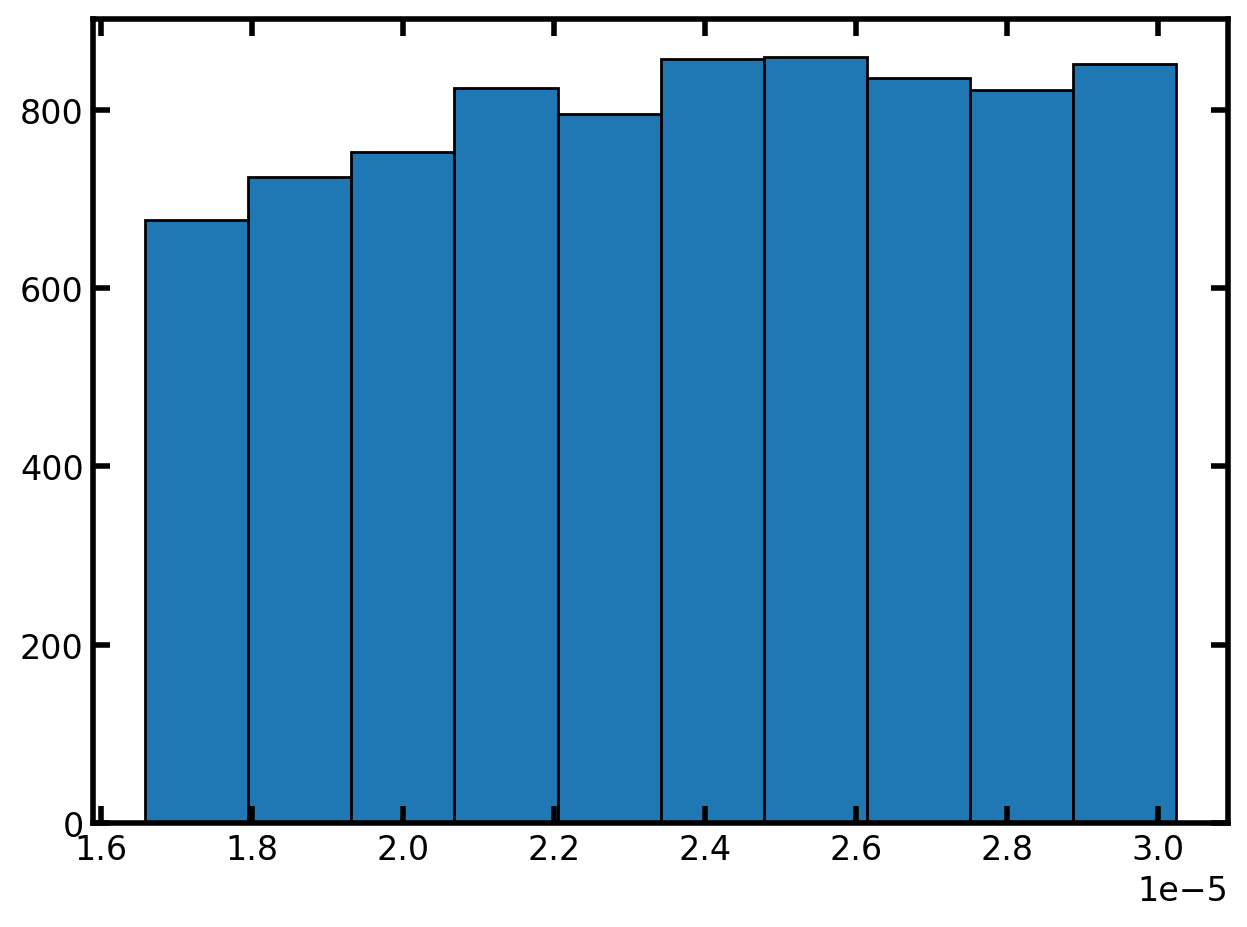

In [41]:
plt.hist(pn['pore.diameter'], edgecolor='k');

In [42]:
# yeah the model looks bad due to the pore.seed values
print(pn.models['pore.seed@all'])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Property Name             Parameter                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
pore.seed                 model:                    random
                          element:                  pore
                          num_range:                [0.2, 0.7]
                          seed:                     None
                          regeneration mode:        deferred
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


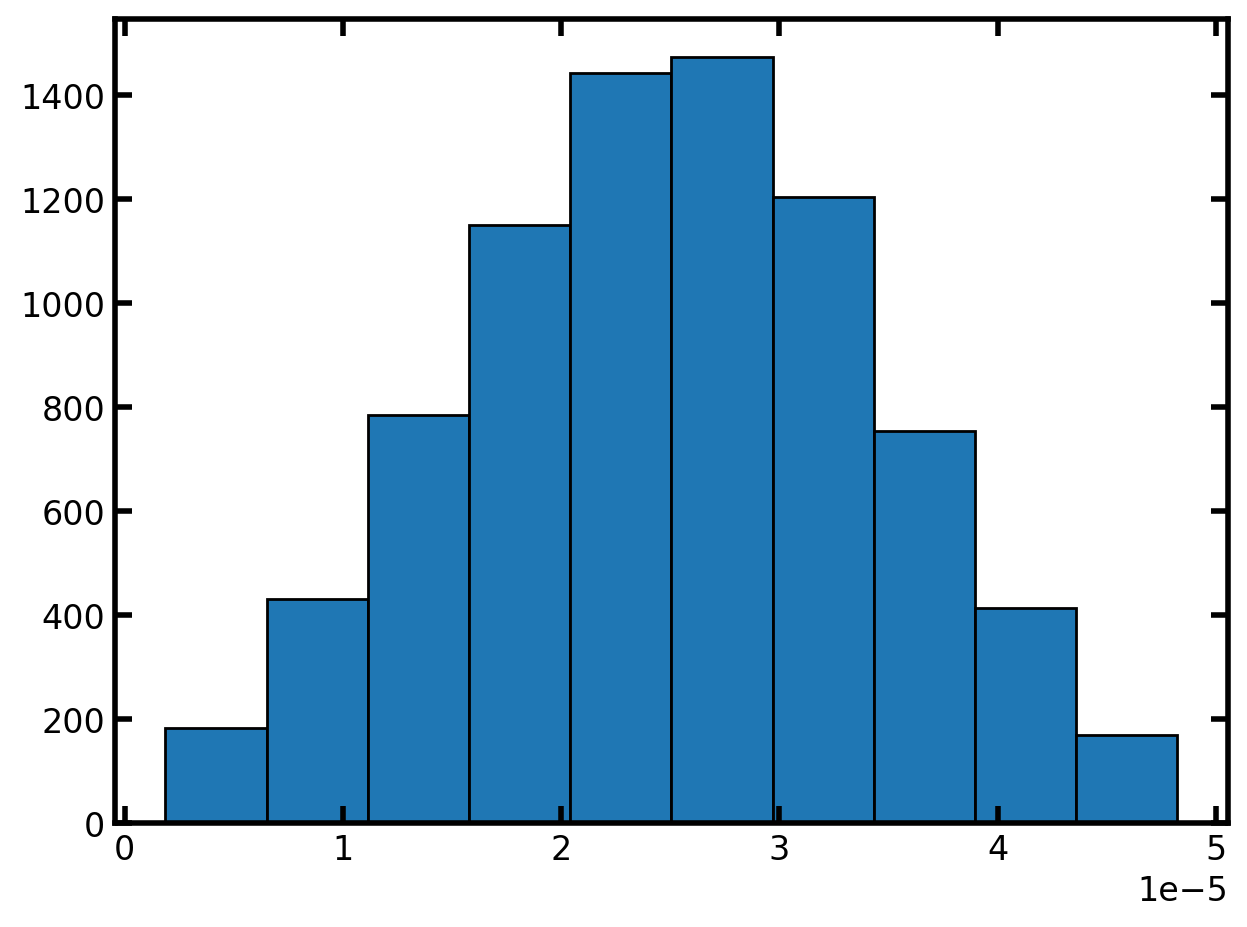

In [43]:
# num_range is constrained - let's use a wider range
pn.models['pore.seed@all']['num_range'] = [0.01, 0.99]
pn.regenerate_models()
plt.hist(pn['pore.diameter'], edgecolor='k');

In [44]:
# Dependency handler
# regenerate_models will automatically update all models that depend on the model being updated
# e.g. pore.seed updated will also update throat.diameter and pore.diameter
pn = op.network.Cubic(shape=[20, 20, 20], spacing=5e-5)
pn.add_model(propname='pore.seed',
             model=op.models.geometry.pore_seed.random)
pn.add_model(propname='pore.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='pore.seed')
pn.add_model(propname='throat.seed',
             model=op.models.geometry.throat_seed.from_neighbor_pores,
             prop='pore.seed')
pn.add_model(propname='throat.diameter',
             model=f,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='throat.seed')
print(pn['pore.seed'])
print(pn['throat.diameter'])

[0.36618201 0.35063831 0.40236746 ... 0.58822388 0.42461491 0.9016327 ]
[2.11640227e-05 2.11640227e-05 2.20171387e-05 ... 2.57748463e-05
 2.30989878e-05 3.79091080e-05]


In [45]:
pn.regenerate_models()
print(pn['pore.seed'])
print(pn['throat.diameter'])

[0.36925632 0.211326   0.47690477 ... 0.58837572 0.58779796 0.51316305]
[1.69817122e-05 1.69817122e-05 1.10980184e-05 ... 1.89392109e-05
 2.72188414e-05 2.53300085e-05]


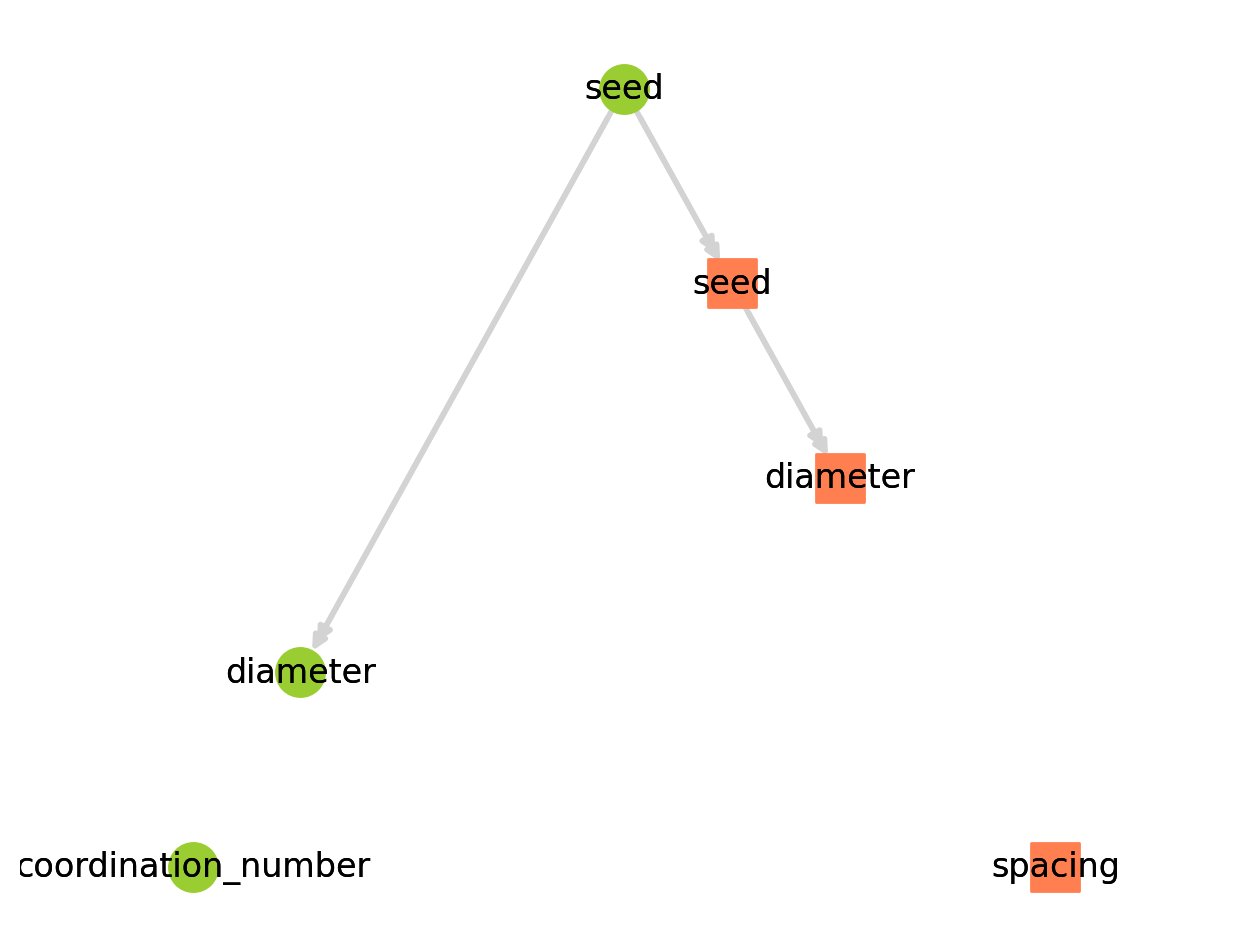

In [46]:
# visualizing this dependency (gree = pores, orange = throats)
pn.models.dependency_map(style='planar');

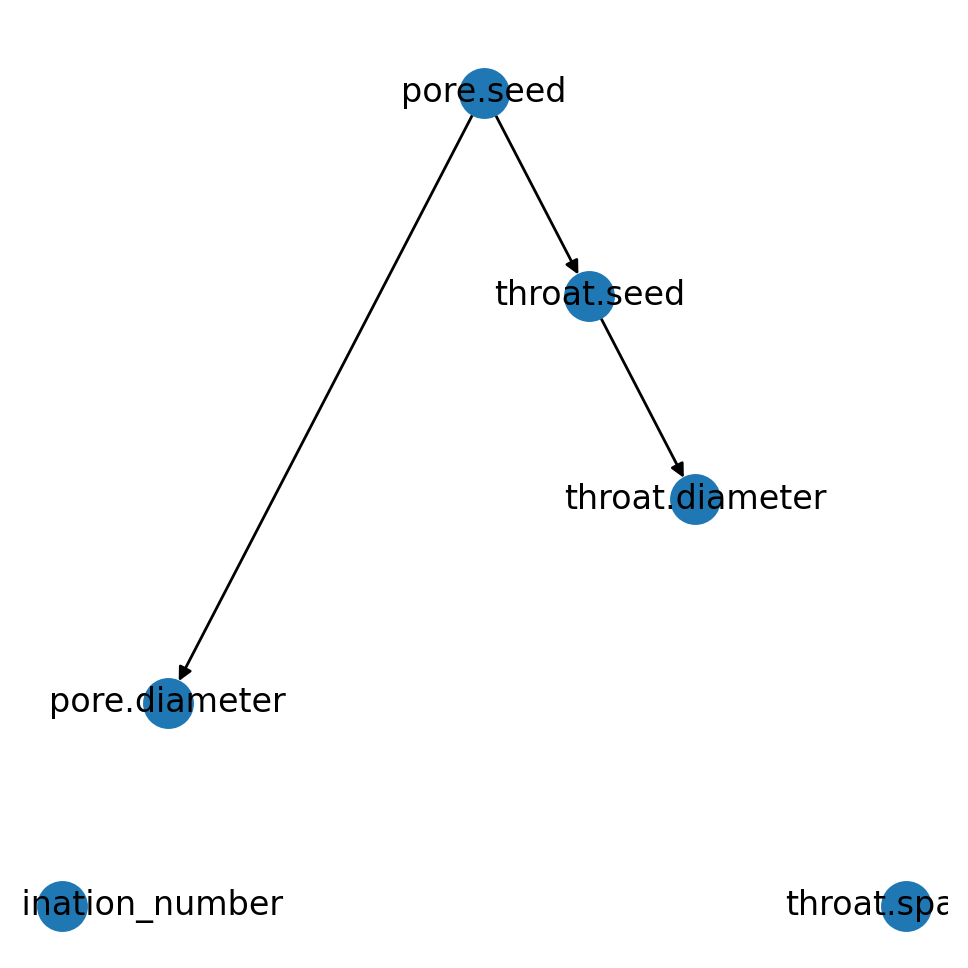

In [47]:
# another way of visualizing dependencies
import networkx as nx
g = pn.models.dependency_graph()
fig, ax = plt.subplots(figsize=[5, 5])
nx.draw_networkx
nx.draw_planar(g, labels={k: k for k, v in g.nodes.items()}, ax=ax)